In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agentic_rag_justmov"

LANGCHAIN_API_KEY: ··········


In [2]:
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
pip install pypdf


  Using cached pypdf-5.1.0-py3-none-any.whl.metadata (7.2 kB)
Using cached pypdf-5.1.0-py3-none-any.whl (297 kB)


In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
docs = PyPDFLoader("Horizon Estates Sales Playbook.pdf").load()
text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)
print(all_splits)

In [14]:
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

In [15]:
from langchain_chroma import Chroma
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  
)
vector_store.add_documents(documents=all_splits)

['0248adb3-e4c0-4f86-8a0c-42b6b9f7ca71',
 '0439d113-1460-46f1-9812-02ab3c120c08',
 'b8a172f4-3d8a-435e-ad4d-f3a52a1ce54e',
 'b17a2cad-e3c1-4c6e-8db8-8f4e4c654504',
 'd1157ccc-1429-4485-83ce-7cdc82d4a396']

In [18]:
from langchain.tools.retriever import create_retriever_tool
retriever = vector_store.as_retriever()
retriever_tool = create_retriever_tool(retriever,name="retrieve_info",description="Retrieve the most relevant info from Horizon Estate's sales playbook")
tools = [retriever_tool]

In [23]:
from langchain.prompts import PromptTemplate
from langgraph.graph import MessagesState
def frame_ques(state):
  """
    From the conversation of two people in a meeting, searches for the important question that person2 has asked and passes it to the agent node.

    Args:
        state (messages): The current state

    Returns:
        The updated state with the agent response appended to messages.
  """
  messages = state['messages']
  conv = messages
  prompt = PromptTemplate(
      template='''
      You are a meeting assistant for Sales agent working at Horizon Estate and from the given conversation: {conv}
      Your task is to find answers to the question asked to the sales agent by client.
      ''', input_variables=["conv"]
  )
  llm = ChatOpenAI(model="gpt-4o-mini")
  llm = llm.bind_tools(tools)
  chain = prompt | llm
  ques = chain.invoke({"conv":conv})
  return {"messages":[ques]}


In [27]:
from langchain import hub
def generate(state):
  messages = state['messages']
  question = messages[0].content
  last_message = messages[-1]
  docs = last_message.content
  prompt = hub.pull("rlm/rag-prompt")
  rag_chain = prompt | llm 
  response = rag_chain.invoke({"context":docs, "question":question})
  return {"messages":[response]}

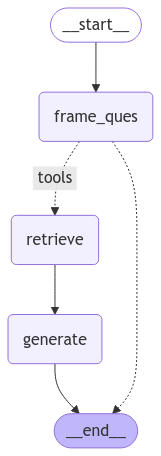

In [33]:
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
builder = StateGraph(MessagesState)

# Define nodes: these do the work
retrieve = ToolNode(tools)
builder.add_node("frame_ques", frame_ques)
builder.add_node("retrieve",retrieve)
builder.add_node("generate",generate)
builder.add_edge(START, "frame_ques")
builder.add_conditional_edges(
    "frame_ques",
    tools_condition,
    {
        "tools":"retrieve",
        END:END,
    },
)
builder.add_edge("retrieve","generate")
builder.add_edge("generate", END)
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [34]:
messages = [HumanMessage(content="Sales Agent: Good afternoon! Welcome to Horizon Estate. How can I assist you today? Client: Hi, Im looking for a residential property in banglore")]
messages = react_graph.invoke({"messages": messages})

In [35]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Sales Agent: Good afternoon! Welcome to Horizon Estate. How can I assist you today? Client: Hi, Im looking for a residential property in banglore
================================== Ai Message ==================================
Tool Calls:
  retrieve_info (call_GHjO5nAr7N6ijBSuXWVDX5Zh)
 Call ID: call_GHjO5nAr7N6ijBSuXWVDX5Zh
  Args:
    query: residential property in Bangalore
================================= Tool Message =================================
Name: retrieve_info

Residential Properties
1. LuxuryApartments-Mumbai○ Location: Bandra, Mumbai○ Description: 3-5BHKluxuryapartmentswithseaviews.○ Amenities: Swimmingpool, gym, clubhouse, and24/7security.○ PriceRange: ₹2.5-₹8crore.2. AffordableHousing-Pune○ Location: Hinjewadi, Pune○ Description: 1-2BHKapartmentsideal forfirst-timebuyers.○ Amenities: Communitycenter, children’splayarea, andgreenspaces.○ PriceRange: ₹40-₹80lakh.3. Ultra-ModernVillas-Hyd